## Importing the main libraries

I’ve chosen to place nearly all the libraries used at the start of the ‘.ipynb‘ file,
as this aligns with my usual practice

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn .metrics import accuracy_score , recall_score , precision_score,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
from random import shuffle
from sklearn.ensemble import  AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier


## Reading the data

The columns didn’t have a name in the csv file so i have put them the
corresponding names from the dataset website for a more organised approach.

In [2]:
column=['Mean_integrated_profile',
       'std_integrated_profile',
       'Excess_kurtosis_integrated_profile',
       'Skewness_integrated_profile', 'Mean_DM_SNR',
       'std_DM_SNR',
       'Excess_kurtosis_DM_SNR', 'Skewness_DM_SNR',
       'target_class']

In [3]:
path='data.csv'
df=pd.read_csv(path,sep = "," , encoding = "utf-8")

In [4]:
df.columns=column

### Correlation Heatmap

This dataset has only 8 features. I have decided to do a correlation matrix of them to see if there are any features that need to be eliminated due to strong correlations to each other or they have little to no correlation to the target itself. I decided to eliminate the ”’Excess kurtosis DM
SNR” and ”Excess kurtosis integrated profile” features due to high correlations
with other features.

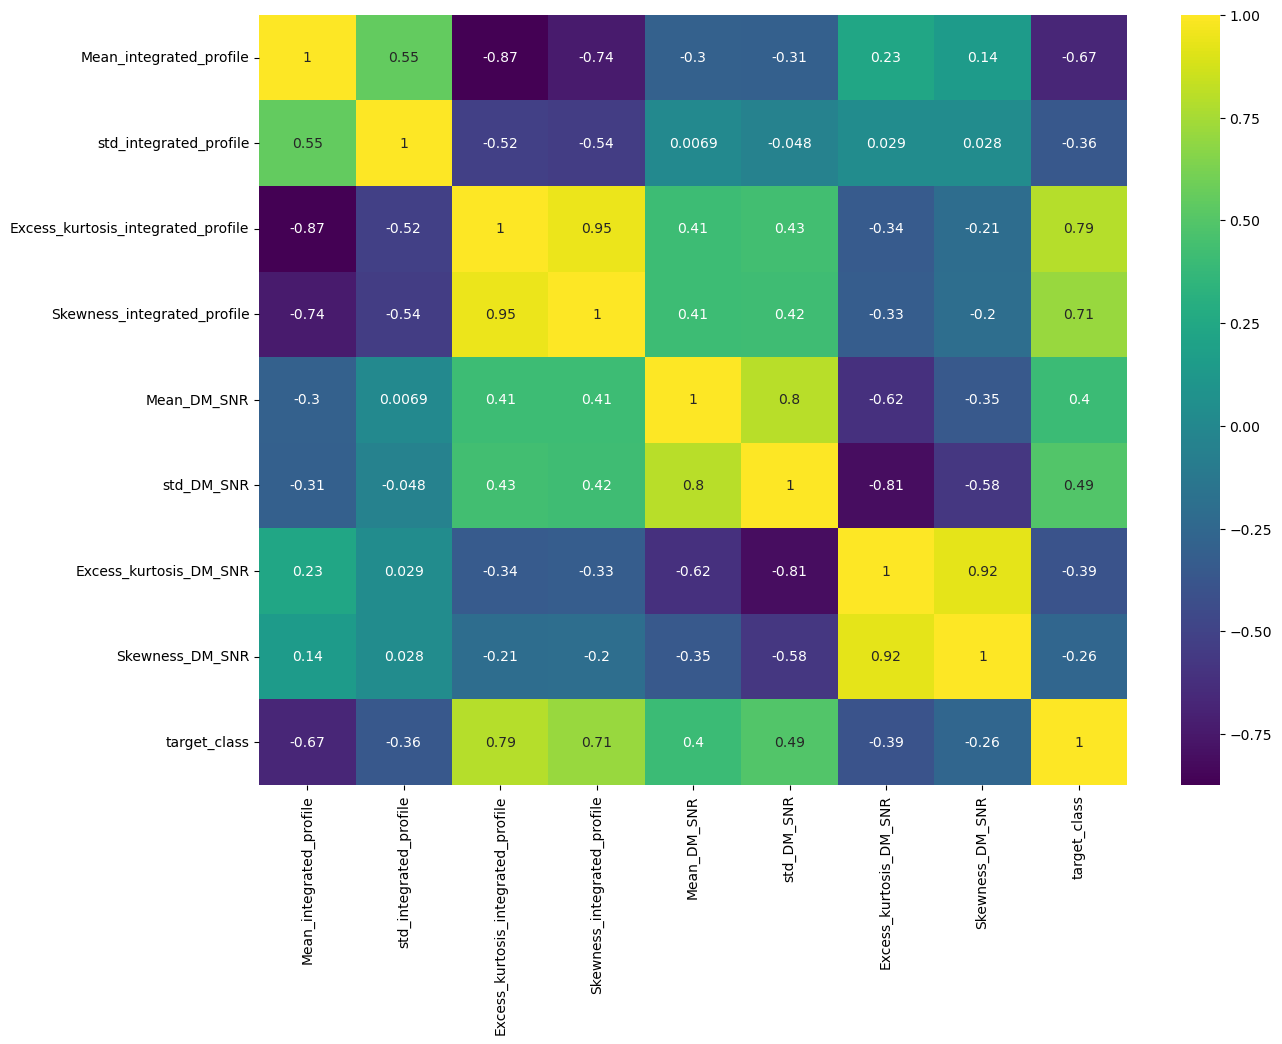

In [5]:
fig=plt.figure(figsize = (14, 10))
corr_mat = df.corr()
sns.heatmap(corr_mat, xticklabels = corr_mat.columns,cmap='viridis', yticklabels = corr_mat.columns, annot=True)
plt.show()

Dropping Features

In [6]:
df.drop(['Excess_kurtosis_DM_SNR', 'Excess_kurtosis_integrated_profile'],axis=1,inplace=True) 

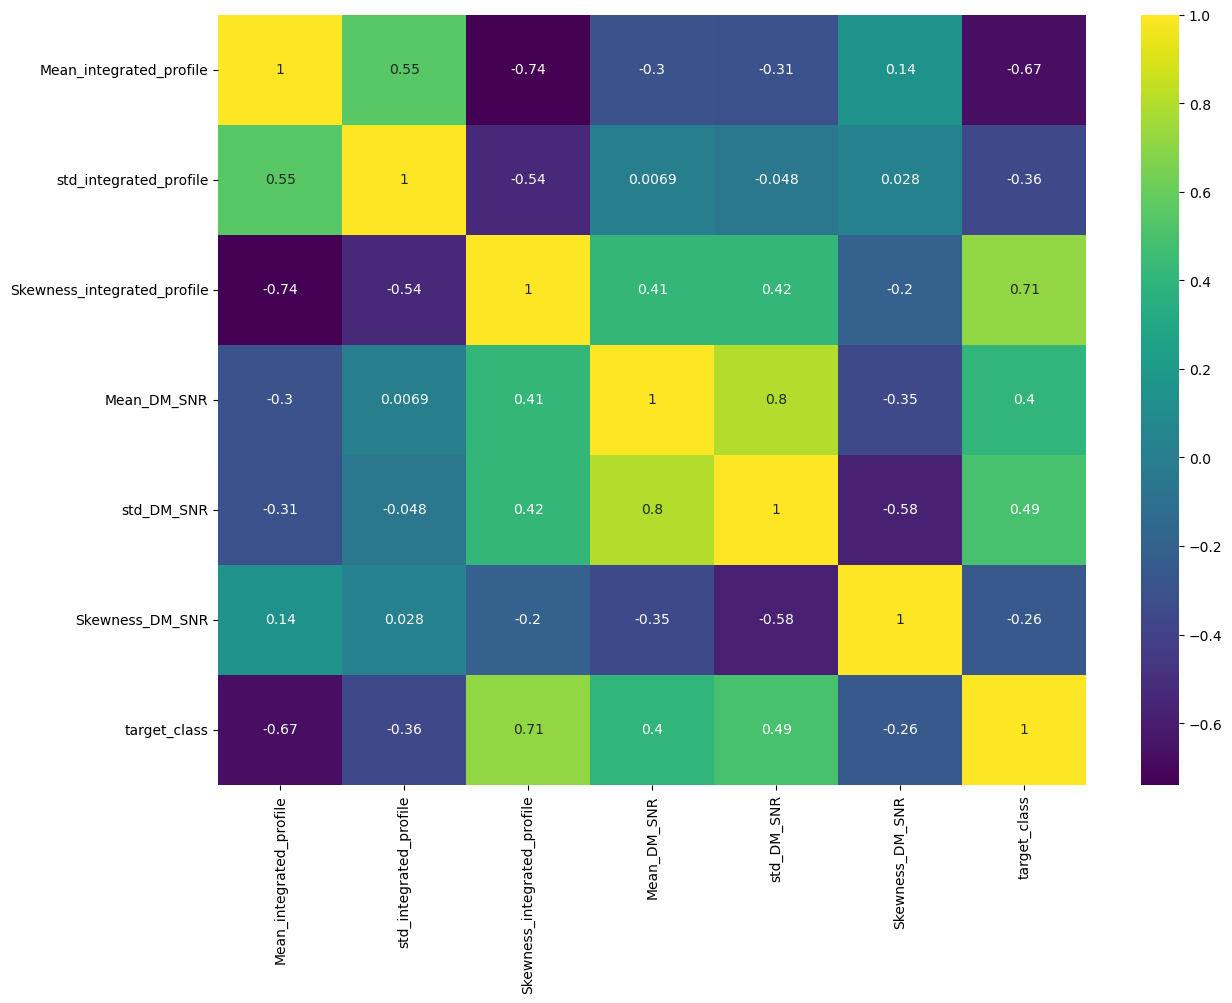

In [7]:
fig=plt.figure(figsize = (14, 10))
corr_mat = df.corr()
sns.heatmap(corr_mat, xticklabels = corr_mat.columns,cmap='viridis', yticklabels = corr_mat.columns, annot=True)
plt.show()

## Split the data

I splitted the features (x) from the label (y) and i plotted each pair (x, y) to
check for outliers

In [8]:
x = df.drop('target_class',axis=1)
y = df['target_class'].values

## Plots

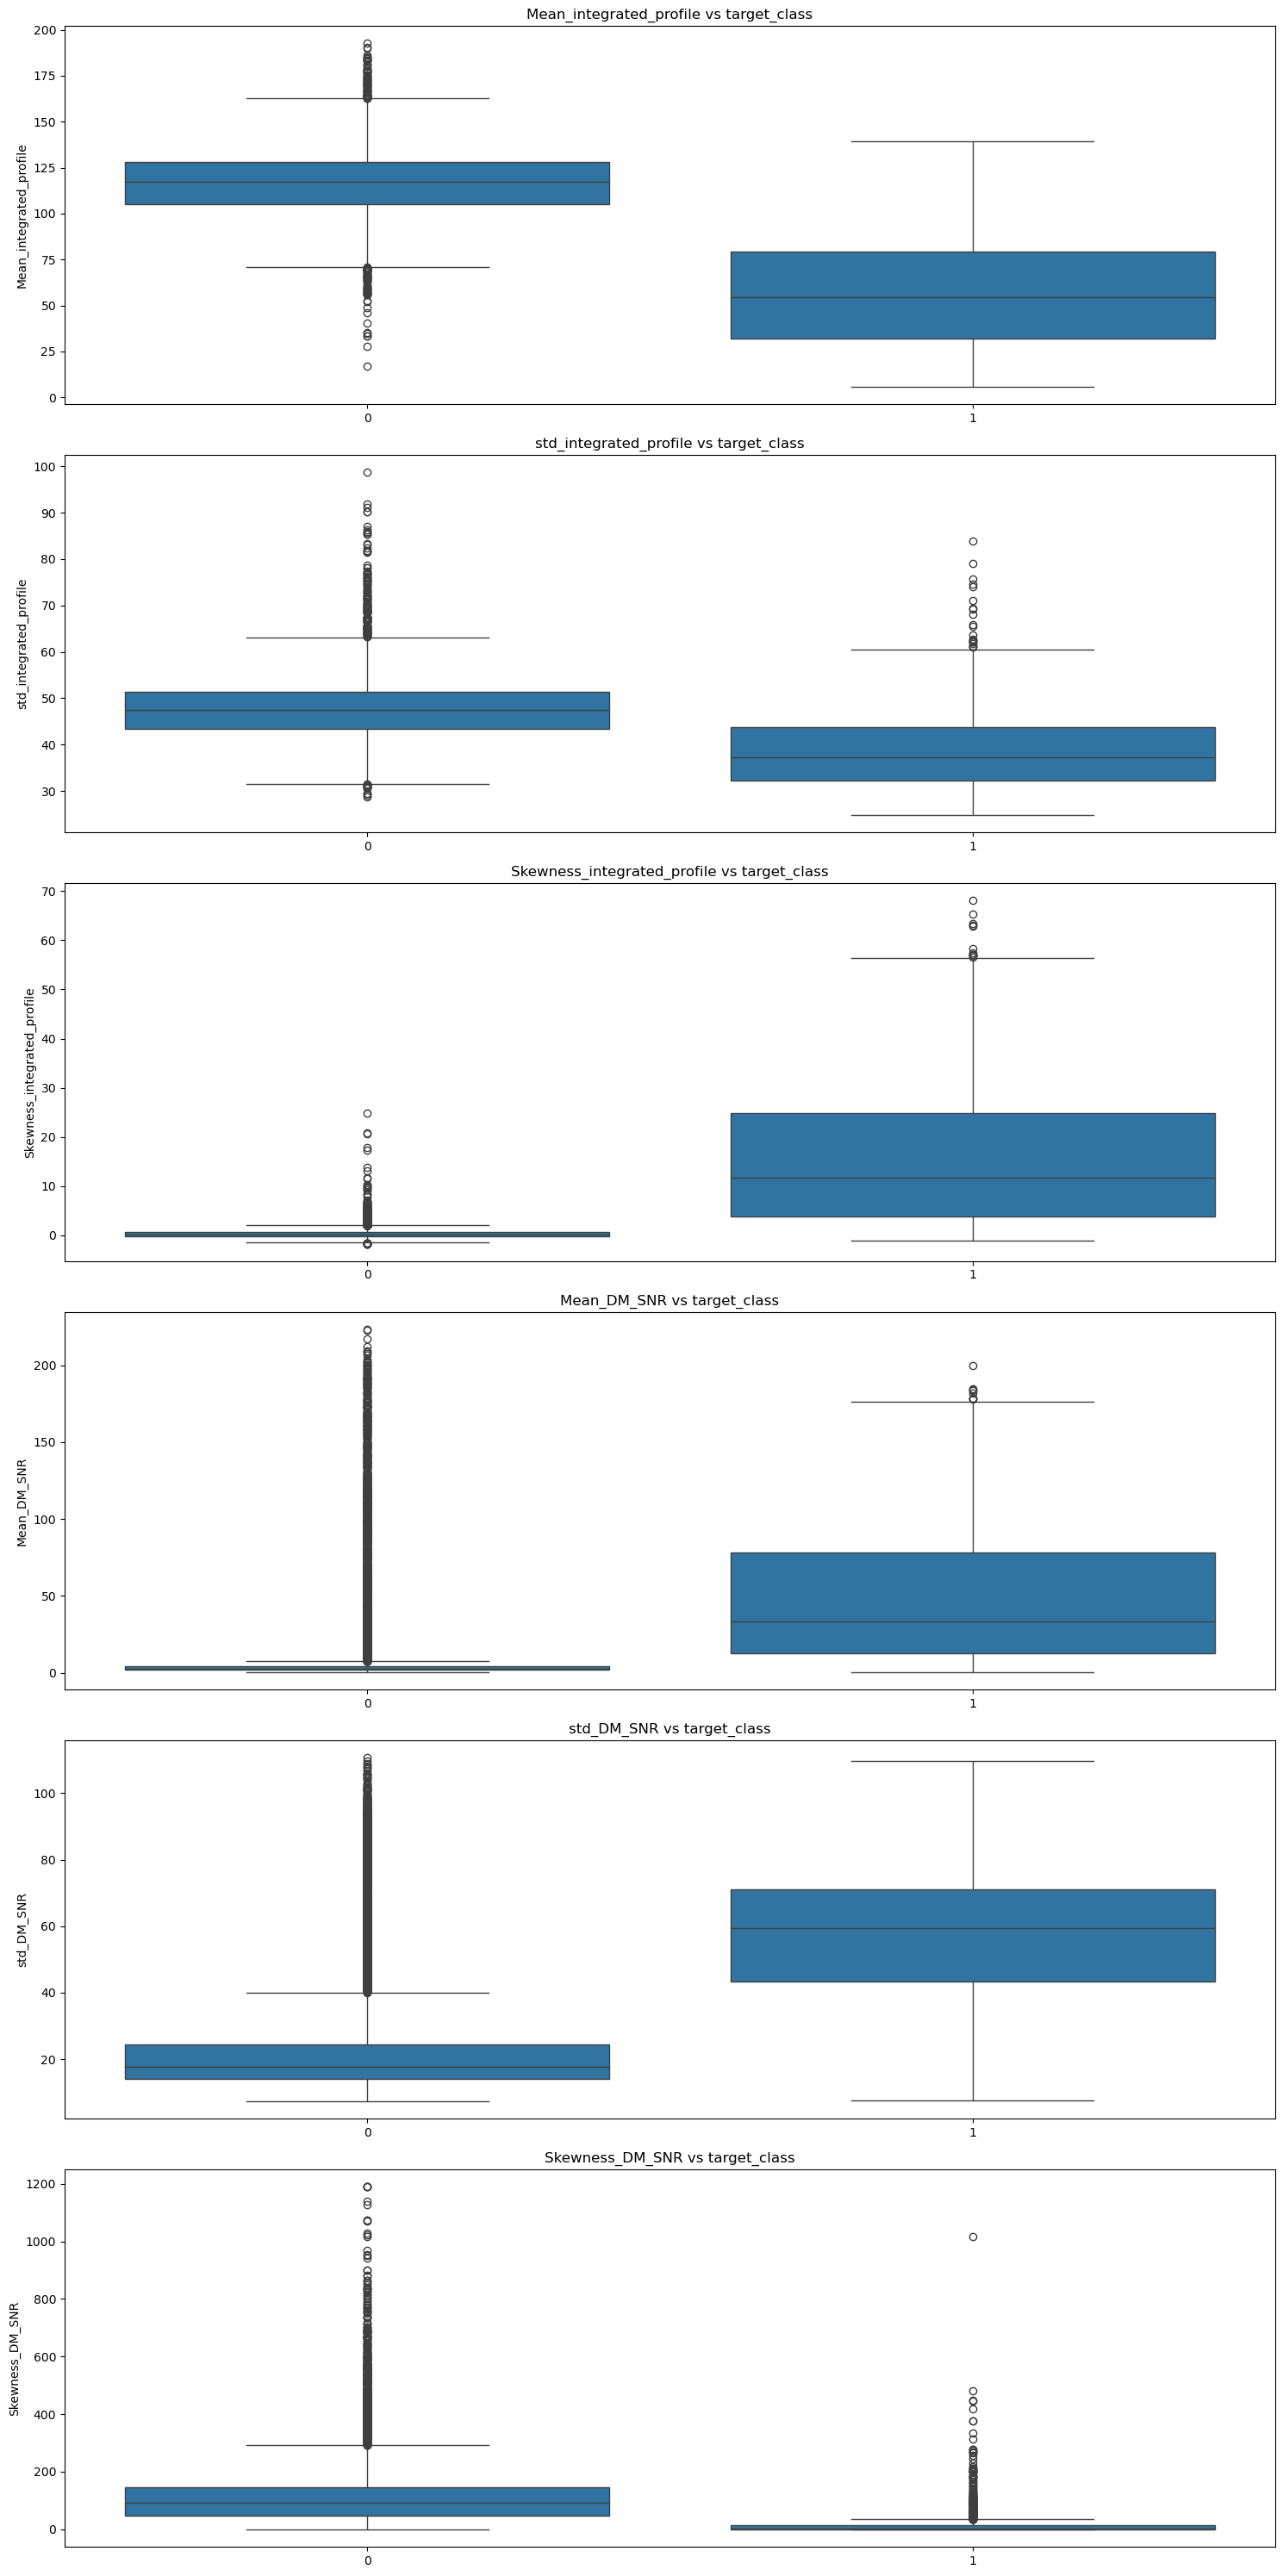

In [9]:
# Set up the matplotlib figure
plt.figure(figsize=(15, len(x.columns) * 5))

# Iterate through each feature in x
for i, col in enumerate(x.columns):
    plt.subplot(len(x.columns), 1, i + 1)
    sns.boxplot(x=y, y=x[col])
    plt.title(f'{col} vs target_class')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Using this simple code, i have decided to eliminate a data point
that looked very far from the IQR range (last plot). I did this
just as an exercise to learn how to remove outliers from datasets.

I must add that there are many outliers that could be removed from the
dataset because they are not within IQR. As a future plan, i will improve the
accuracy metrics of this program by finding which candidates to eliminate from
the dataset

In [10]:
mask = (x['Skewness_DM_SNR'] <= 800) | (y != 1)
x = x[mask]
y = y[mask]

## Scaling

I have used RobustScaler and MinMaxScaler in the final implementation of this
program. This pair gave me the best accuracy metrics for the dataset used.
The Robust Scaler is effective in reducing the impact of outliers by using the
median and interquartile range for scaling, which is crucial given the presence
of noise and anomalies in pulsar signal data. Following this, the MinMax Scaler
can normalize these adjusted values to a specific range, 0 to 1, enhancing the
performance of this ML algorithm. This two-step scaling process ensures that
the data is both outlier-resistant and optimally scaled for subsequent analysis.


first applying the RobustScaler

In [11]:
from sklearn import preprocessing
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df,columns=list(x.columns ))

after that applying the MinMaxScaler

In [12]:
scaler = MinMaxScaler()
x = scaler.fit_transform(robust_df)

## Splitting data into train and test

I’ve used a 75/25 training to testing ratio for this code.

In [13]:
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size=0.25,random_state = 1234)

## Modeling

- LogisticRegression
- DecisionTreeClassifier
- RandomForestClassifier
- KNeighborsClassifier
- XGBClassifier
- VotingClassifier ( hard , soft)
- SVM

### Performance Metrics
- Confusion Matrix
- Precision
- Recall
- F1-Score
- AUC & ROC Curve

## PrintReportFunction

Using ChatGPT, I developed a print report function that simplifies our
workflow by removing the need to repeatedly paste the same code for each model.
This function not only makes our tasks more straightforward but also streamlines the entire analysis process. Additionally, every time this function is run, it
records the model and its performance metrics in a dictionary named ”compa,”
further facilitating the comparison of different algorithms. This enhancement
significantly eases the evaluation and comparison stages of our project.


In [14]:
compa={'model':[],
       'train_score':[],
       "accuracy":[],
      'recall':[],
      'precision':[],
      'f1_score':[]}

In [15]:
def print_report(model,name,color):
    y_pred = model.predict(x_test)

    accuracy=accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1_scor=f1_score(y_test, y_pred)
    
    print('recall  = {}'.format(np.round(recall,3)))
    print('Precision   = {}'.format(np.round(precision,3)))
    print('f1_score   = {}'.format(np.round(f1_scor,3)))

    compa['f1_score'].append(f1_scor)
    compa['accuracy'].append(accuracy)
    compa['recall'].append(recall)
    compa['precision'].append(precision)
    compa['model'].append(name) 
    
    print("accuracy score = {}".format(np.round(accuracy,3)))

    print(classification_report(y_test, y_pred,target_names=['Non Pulsar','Pulsar']))
    confusion_matrix=metrics.confusion_matrix(y_pred,y_test)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    fig, ax = plt.subplots(figsize=(6,5))
    ax.grid(False)
    cm_display.plot(ax=ax,cmap=color)
    plt.show()

## Logistic Regression

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best model parameters: LogisticRegression(C=10000.0, penalty='l1', solver='liblinear')
recall  = 0.775
Precision   = 0.946
f1_score   = 0.852
accuracy score = 0.974
              precision    recall  f1-score   support

  Non Pulsar       0.98      1.00      0.99      4047
      Pulsar       0.95      0.78      0.85       427

    accuracy                           0.97      4474
   macro avg       0.96      0.89      0.92      4474
weighted avg       0.97      0.97      0.97      4474



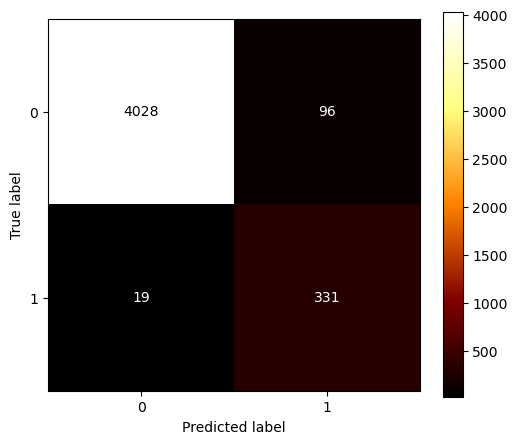

In [16]:
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Define a parameter grid to tune the Logistic Regression model
parameters = {
    'penalty': ['l1', 'l2'],  # Types of regularization penalties
    'C': np.logspace(-4, 4, 10),  # Regularization strength, logarithmically spaced
    'solver': ['liblinear', 'saga']  # Solvers that support both l1 and l2 penalties
}

# Initialize and configure GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=parameters,
    scoring='accuracy',  # Metric used for optimization
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Verbose output to track progress
    error_score='raise'  # Raise on errors
)

# Perform grid search to find the best hyperparameters
best_clf_grid = grid_search.fit(x_train, y_train)

# Print the configuration of the best model
print("Best model parameters:", best_clf_grid.best_estimator_)

# Extract the best model for further use
bestlr_model = best_clf_grid.best_estimator_

# Fit the best model on the training data
bestlr_model.fit(x_train, y_train)

# Function to print or plot the model report
print_report(model=bestlr_model, name="LogisticRegression GS", color='afmhot')

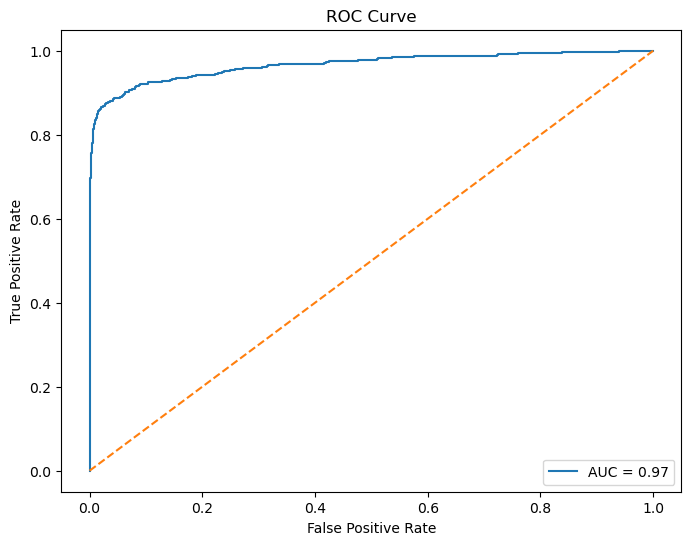

In [17]:
y_prob = bestlr_model.predict_proba(x_test)[:, 1]
auc = roc_auc_score(y_test, y_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')  # Plot the diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


## Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
recall  = 0.82
Precision   = 0.893
f1_score   = 0.855
accuracy score = 0.973
              precision    recall  f1-score   support

  Non Pulsar       0.98      0.99      0.99      4047
      Pulsar       0.89      0.82      0.85       427

    accuracy                           0.97      4474
   macro avg       0.94      0.90      0.92      4474
weighted avg       0.97      0.97      0.97      4474



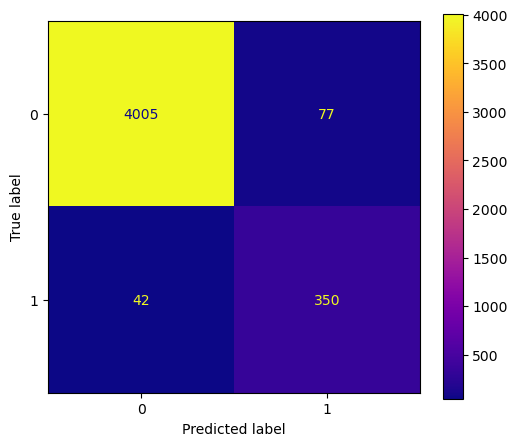

In [19]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50 ,60, 70, 80, 90, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid,scoring='accuracy', cv=5)
grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
bestdt_model = grid_search.best_estimator_

bestdt_model.fit(x_train, y_train)


print_report(model=bestdt_model,name="DecisionTreeClassifier",color='plasma')

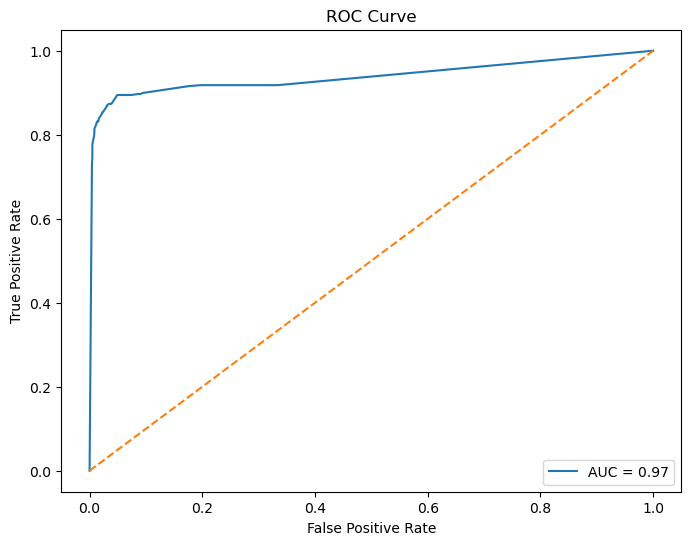

In [20]:


y_score = bestdt_model.predict_proba(x_test)[:, 1]

auc = roc_auc_score(y_test, y_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')  # Plot the diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest

recall  = 0.838
Precision   = 0.932
f1_score   = 0.883
accuracy score = 0.979
              precision    recall  f1-score   support

  Non Pulsar       0.98      0.99      0.99      4047
      Pulsar       0.93      0.84      0.88       427

    accuracy                           0.98      4474
   macro avg       0.96      0.92      0.94      4474
weighted avg       0.98      0.98      0.98      4474



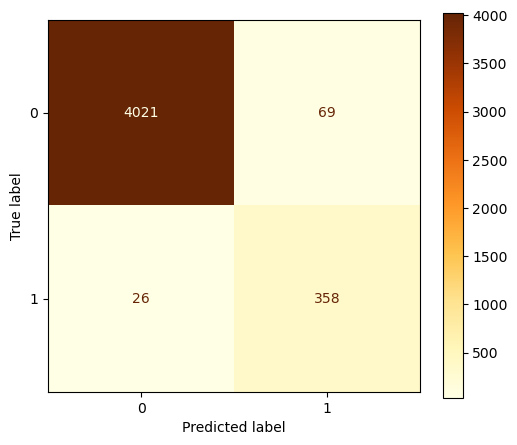

In [21]:
modelrf = RandomForestClassifier()
modelrf.fit(x_train, y_train)
print_report(model=modelrf,name="RandomForestClassifier",color='YlOrBr')

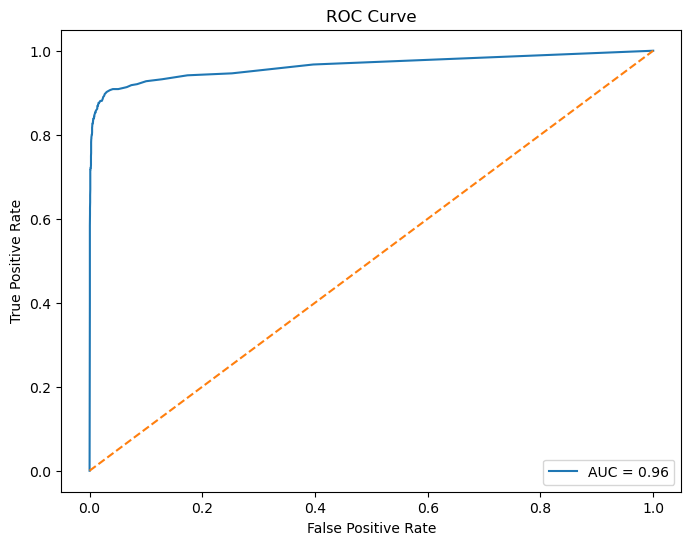

In [22]:


# Get the probability scores of positive class from RandomForest
y_score = modelrf.predict_proba(x_test)[:, 1]

# Calculate the AUC score
auc = roc_auc_score(y_test, y_score)

# Generate the data for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## KNN

[ 3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45 47 49]


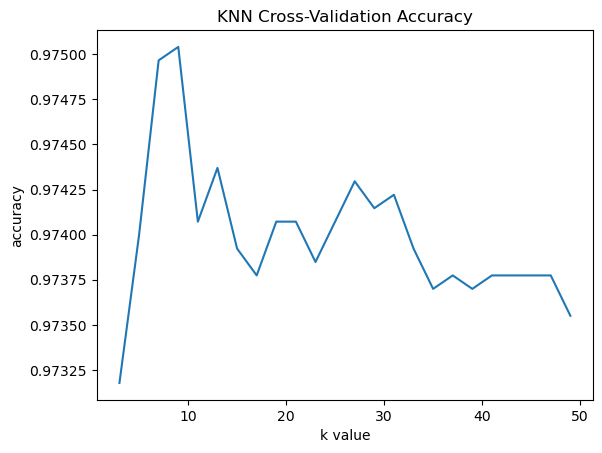

Best k value: 9
recall  = 0.806
Precision   = 0.922
f1_score   = 0.86
accuracy score = 0.975
              precision    recall  f1-score   support

  Non Pulsar       0.98      0.99      0.99      4047
      Pulsar       0.92      0.81      0.86       427

    accuracy                           0.97      4474
   macro avg       0.95      0.90      0.92      4474
weighted avg       0.97      0.97      0.97      4474



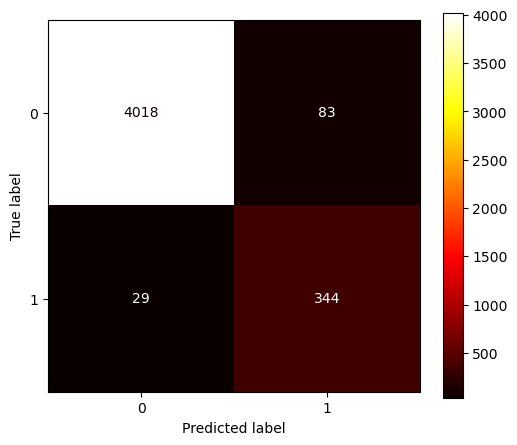

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
max_k_range = x_train.shape[0] // 2
k_list = [i for i in range(3, 51, 2)]

k_array = np.array(k_list)
print(k_array)

# Initialize a list to hold cross-validation scores
cross_validation_scores = [] # this is a list
all_scores={} # this is a dictionary b/c each k value is associated with a score

# Create a KFold object for cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=35)

# Perform cross-validation for each value of 'k'
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=kf, scoring='accuracy')
    cross_validation_scores.append(scores.mean())
    all_scores[k] = scores  # Store the 10 accuracy scores for each 'k'

number_of_CV_scores = len(cross_validation_scores)
# Plot the cross-validation scores against the 'k' values
plt.plot(k_list, cross_validation_scores)
plt.xlabel('k value')
plt.ylabel('accuracy')
plt.title('KNN Cross-Validation Accuracy')
plt.show()

new_k = k_list[cross_validation_scores.index(max(cross_validation_scores))]
print(f"Best k value: {new_k}")


bestknn_model = KNeighborsClassifier(n_neighbors=new_k)
bestknn_model.fit(x_train, y_train)
print_report(model=bestknn_model,name="KNeighborsClassifier",color='hot')

AUC Score: 0.9487491529562766


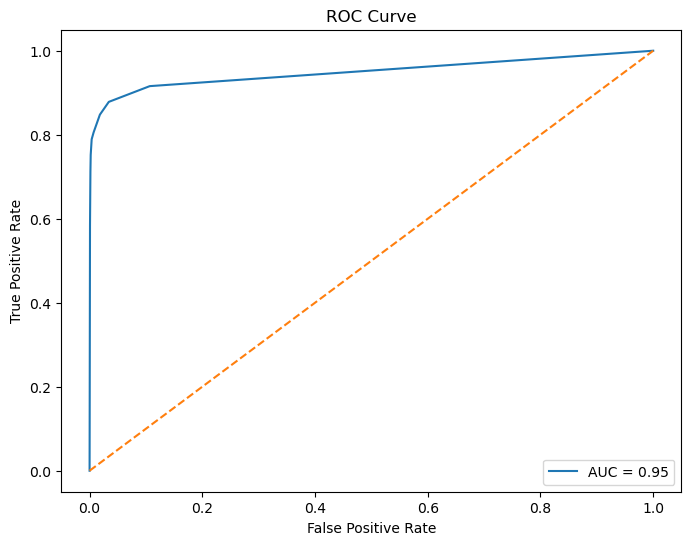

In [24]:


# Get the probability scores of positive class from K-Nearest Neighbors
y_score = bestknn_model.predict_proba(x_test)[:, 1]

# Calculate the AUC score
auc = roc_auc_score(y_test, y_score)
print("AUC Score:", auc)

# Generate the data for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## XGBoost

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters: {'colsample_bytree': 1, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.75}
recall  = 0.848
Precision   = 0.926
f1_score   = 0.885
accuracy score = 0.979
              precision    recall  f1-score   support

  Non Pulsar       0.98      0.99      0.99      4047
      Pulsar       0.93      0.85      0.89       427

    accuracy                           0.98      4474
   macro avg       0.95      0.92      0.94      4474
weighted avg       0.98      0.98      0.98      4474



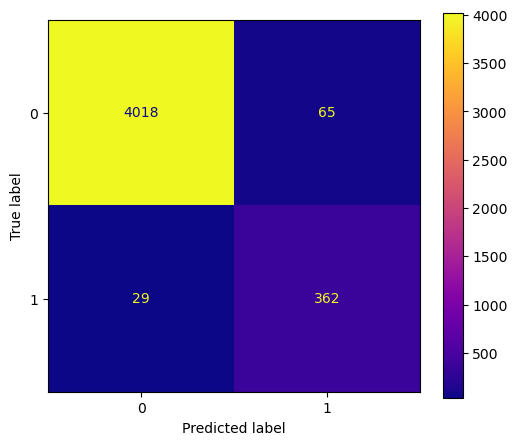

In [26]:
# model = XGBClassifier(nthread=-1)
# model.fit(x_train, y_train)
# print_report(model=model,name="XGBClassifier",color='Greys')

import xgboost as xgb

param_grid = {
    'max_depth': [3, 6, 10],  # Typical values to control overfitting
    'learning_rate': [0.01, 0.1, 0.3],  # Also known as eta
    'n_estimators': [100, 200, 300],
    'subsample': [0.5, 0.75, 1],  # Subsample ratio of the training instances
    'colsample_bytree': [0.5, 0.75, 1],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2]  # Minimum loss reduction required to make a further partition
}

# Initialize the XGBClassifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,  # Show progress
    n_jobs=-1  # Use all available CPUs
)

# Fit GridSearchCV
grid_search.fit(x_train, y_train)

# Best parameters and model
print("Best parameters:", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_

# Optional: Fit the best model (not necessary here since GridSearchCV already refits the best model)
best_xgb_model.fit(x_train, y_train)

# Assuming print_report is a custom function for reporting
print_report(model=best_xgb_model, name="XGBClassifier", color='plasma')



AUC Score: 0.9737990786247539


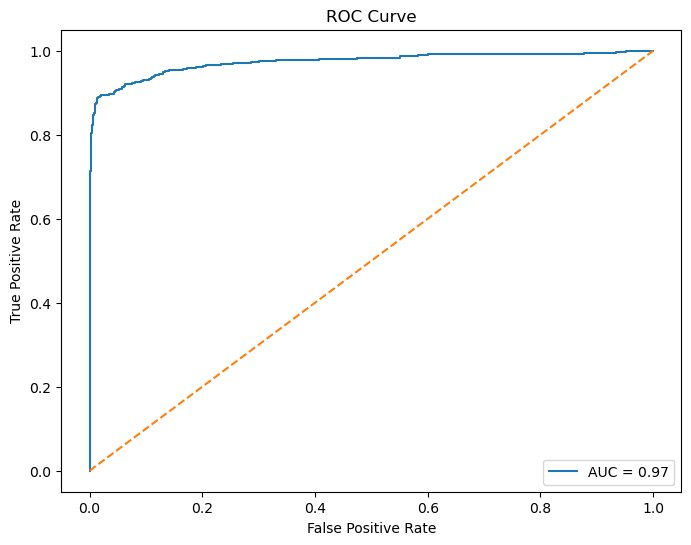

In [27]:


# Get the probability scores of positive class from XGBoost
y_score = best_xgb_model.predict_proba(x_test)[:, 1]

# Calculate the AUC score
auc = roc_auc_score(y_test, y_score)
print("AUC Score:", auc)

# Generate the data for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Plotting the ROC curve using matplotlib
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')  # Plot the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')  # Add the diagonal line for reference
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.title('ROC Curve')  # Title of the plot
plt.legend(loc='lower right')  # Position of the legend
plt.show()  # Display the plot

### Hard Voting

recall  = 0.831
Precision   = 0.937
f1_score   = 0.881
accuracy score = 0.979
              precision    recall  f1-score   support

  Non Pulsar       0.98      0.99      0.99      4047
      Pulsar       0.94      0.83      0.88       427

    accuracy                           0.98      4474
   macro avg       0.96      0.91      0.93      4474
weighted avg       0.98      0.98      0.98      4474



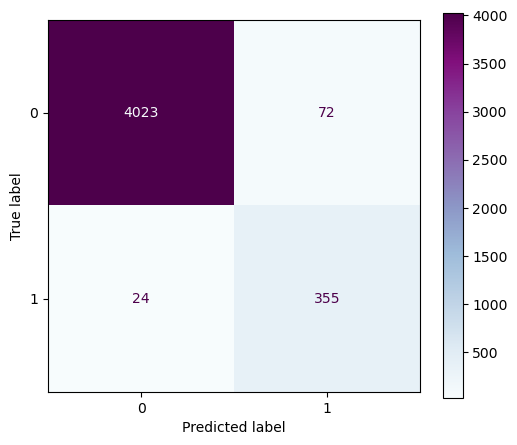

In [28]:


estimators = [('lr',LogisticRegression()),
              ('dt',DecisionTreeClassifier()),
              ('rf',RandomForestClassifier()),
              ('ab',AdaBoostClassifier()),
              ('xg',XGBClassifier())]
hardmodel = VotingClassifier(estimators=estimators,voting='hard')
hardmodel.fit(x_train, y_train)
print_report(model=hardmodel,name="hardVotingClassifier",color='BuPu')

### Soft Voting

recall  = 0.82
Precision   = 0.933
f1_score   = 0.873
accuracy score = 0.977
              precision    recall  f1-score   support

  Non Pulsar       0.98      0.99      0.99      4047
      Pulsar       0.93      0.82      0.87       427

    accuracy                           0.98      4474
   macro avg       0.96      0.91      0.93      4474
weighted avg       0.98      0.98      0.98      4474



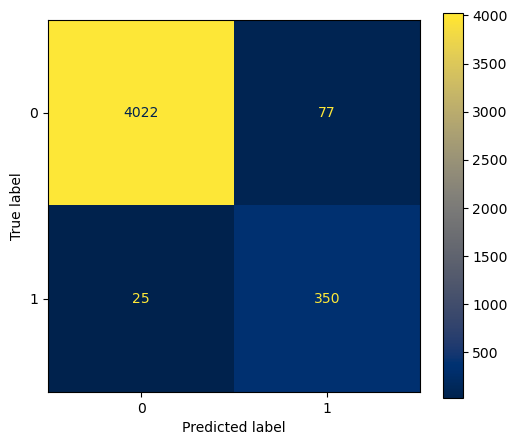

In [29]:
estimators = [('lr',LogisticRegression()),
              ('dt',DecisionTreeClassifier()),
              ('rf',RandomForestClassifier()),
              ('ab',AdaBoostClassifier()),
              ('xg',XGBClassifier())]
softmodel = VotingClassifier(estimators=estimators,voting='soft')
softmodel.fit(x_train, y_train)
print_report(model=softmodel,name="softVotingClassifier",color='cividis')

AUC Score: 0.9708616959160775


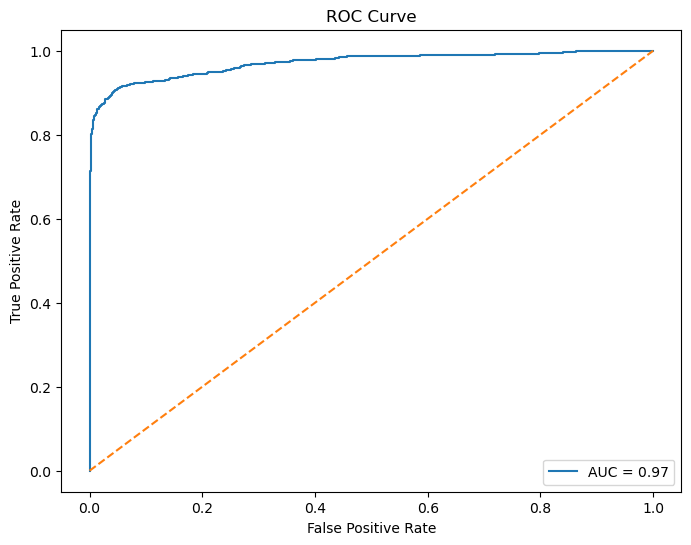

In [30]:


# Get the probability scores of positive class from XGBoost
y_score = softmodel.predict_proba(x_test)[:, 1]

# Calculate the AUC score
auc = roc_auc_score(y_test, y_score)
print("AUC Score:", auc)

# Generate the data for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Plotting the ROC curve using matplotlib
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')  # Plot the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')  # Add the diagonal line for reference
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.title('ROC Curve')  # Title of the plot
plt.legend(loc='lower right')  # Position of the legend
plt.show()  # Display the plot

## SVM

Best parameters found by grid search: {'C': 10, 'coef0': 1, 'degree': 3, 'kernel': 'poly'}
recall  = 0.822
Precision   = 0.951
f1_score   = 0.882
accuracy score = 0.979
              precision    recall  f1-score   support

  Non Pulsar       0.98      1.00      0.99      4047
      Pulsar       0.95      0.82      0.88       427

    accuracy                           0.98      4474
   macro avg       0.97      0.91      0.94      4474
weighted avg       0.98      0.98      0.98      4474



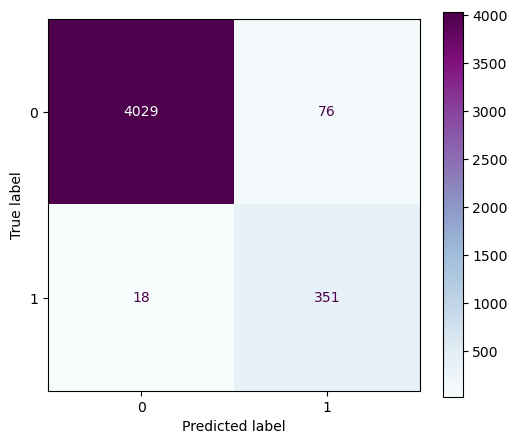

In [31]:
from sklearn import svm
param_grid = [
    {'kernel': ['poly'], 'C': [1, 10], 'degree': [3, 4], 'coef0': [0, 1]},  # Simplified polynomial kernel options
]

# Perform Grid Search
grid_search = GridSearchCV(svm.SVC(probability=True, decision_function_shape='ovr'), param_grid, cv=5)
grid_search.fit(x_train, y_train)

# Print the best parameters
print("Best parameters found by grid search:", grid_search.best_params_)

# Train the best SVM model with the best parameters
best_svc = grid_search.best_estimator_

# Fit the best model on the training data
best_svc.fit(x_train, y_train)

print_report(model=best_svc,name="SVM",color='BuPu')

AUC Score: 0.9723804431420273


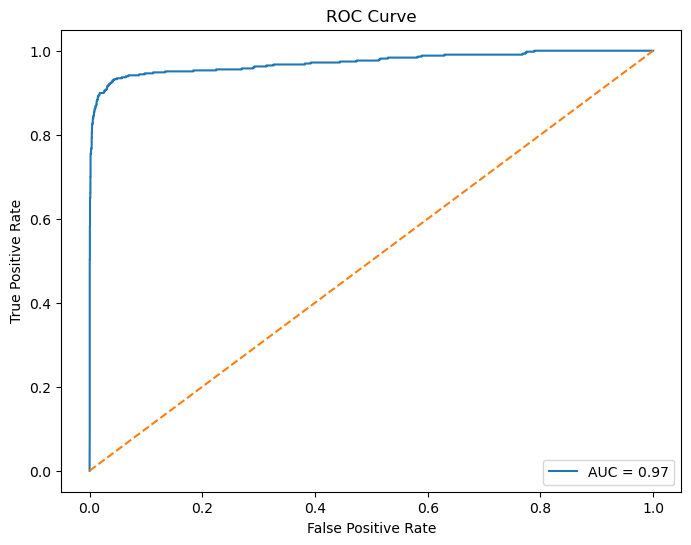

In [32]:


# Get the probability scores of positive class from XGBoost
y_score = best_svc.predict_proba(x_test)[:, 1]

# Calculate the AUC score
auc = roc_auc_score(y_test, y_score)
print("AUC Score:", auc)

# Generate the data for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Plotting the ROC curve using matplotlib
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')  # Plot the ROC curve
plt.plot([0, 1], [0, 1], linestyle='--')  # Add the diagonal line for reference
plt.xlabel('False Positive Rate')  # Label for x-axis
plt.ylabel('True Positive Rate')  # Label for y-axis
plt.title('ROC Curve')  # Title of the plot
plt.legend(loc='lower right')  # Position of the legend
plt.show()  # Display the plot

## Comparision between the models

Using the dictionary ”compa” that stored the models and their performance
metrics,I have done a comparision of all the models described earlier.

In the dataset, all the models demonstrate a pattern where accuracy is the
highest metric, followed by precision, then the F1 score, and finally recall as
the lowest. This occurs because accuracy benefits from the large number of true
negatives in common datasets, boosting its value. Precision, which only looks at
positive predictions, is naturally lower without the boost from true negatives.
The F1 score, which combines precision and recall, is lower still because it’s
dragged down by the typically lower recall. Recall is the lowest because it
measures how many actual positives are correctly identified, and a lower recall
indicates that the model misses many positive cases.

This sequence reflects a trend where the models are efficient at classifying
negatives but less effective at consistently identifying all positives.
The performance metrics chart for various machine learning models illustrates that each model excels in different areas—accuracy, recall, precision, and
F1 score—without a single model consistently outperforming the others across
all metrics.
This variety in strengths suggests that choosing the best model depends on
the specific needs of the application, highlighting the absence of a one-size-fits-all
solution among these options.
Although there is no clear winner in this ”battle”, if i would have to choose
one, i would choose XGBClassifier for this dataset because of its high recall,f1
and decent accuracy and precision.

In [33]:
# Create traces
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=compa["model"], y=compa["accuracy"],
                    mode='lines+markers',
                    name='accuracy'))
fig.add_trace(go.Scatter(x=compa["model"], y=compa["recall"],
                    mode='lines+markers',
                    name='recall'))
fig.add_trace(go.Scatter(x=compa["model"], y=compa["precision"],
                    mode='lines+markers', name='precision'))
fig.add_trace(go.Scatter(x=compa["model"], y=compa["f1_score"],
                    mode='lines+markers', name='f1_score'))

fig.show()

#### 

In [34]:
print(compa['model'])

['LogisticRegression GS', 'DecisionTreeClassifier', 'RandomForestClassifier', 'KNeighborsClassifier', 'XGBClassifier', 'hardVotingClassifier', 'softVotingClassifier', 'SVM']


I have created a user-friendly interface using TKinter, designed for scientists
to input data from detectors and receive immediate predictions (0 means no
pulsar, 1 means pulsar) from various models.

## User interface 

In [35]:
import tkinter as tk
from tkinter import messagebox
from PIL import Image, ImageTk
import numpy as np

# Assume models are imported or defined here
# from model_file import bestlr_model, bestdt_model, modelrf, bestknn_model, best_xgb_model, hardmodel, softmodel, best_svc

def predict():
    try:
        # Collecting the values from the entry fields
        inputs = [float(entry.get()) for entry in entries]
        features = np.array(inputs).reshape(1, -1)
        
        # Dictionary of all models
        models = {
            'Logistic Regression': bestlr_model,
            'Decision Tree': bestdt_model,
            'Random Forest': modelrf,
            'KNN': bestknn_model,
            'XGBoost': best_xgb_model,
            'Voting Classifier Hard': hardmodel,
            'Voting Classifier Soft': softmodel,
            'SVM': best_svc
        }
        
        results = []
        for model_name, model in models.items():
            prediction = model.predict(features)
            results.append(f'{model_name}: {prediction[0]}')
        
        # Show results in a message box
        messagebox.showinfo("Prediction Results", "\n".join(results))
        
    except Exception as e:
        messagebox.showerror("Error", f"Failed to predict, check the input values.\n{e}")

# Create the main window
root = tk.Tk()
root.title("Pulsar Star Predictor")
root.geometry("800x600")

# Load a background image using Pillow
try:
    image = Image.open('wallpaperflare.com_wallpaper.jpg')
    background_image = ImageTk.PhotoImage(image)
    background_label = tk.Label(root, image=background_image)
    background_label.place(x=0, y=0, relwidth=1, relheight=1)
    background_label.lower()
except Exception as e:
    print("Failed to load background image")
    print(e)

# Inputs
labels = [
    'Mean Integrated Profile', 'Std Integrated Profile', 'Skewness Integrated Profile',
    'Mean DM SNR', 'Std DM SNR', 'Skewness DM SNR'
]
entries = []

# Create a frame to hold the labels and entries
input_frame = tk.Frame(root, bg='white')
input_frame.pack(pady=20)

for i, label_text in enumerate(labels):
    label = tk.Label(input_frame, text=label_text, bg='white')
    label.grid(row=i, column=0, padx=10, pady=10, sticky='e')
    entry = tk.Entry(input_frame)
    entry.grid(row=i, column=1, padx=10, pady=10)
    entries.append(entry)

# Button to predict using all models
button = tk.Button(root, text="Predict Using All Models", command=predict)
button.pack(pady=20)

# Start the GUI event loop
root.mainloop()